## Подключаем библиотеки

In [9]:
# работа с файлами
import os

# обработка и рисование изображений
import imageio
from PIL import Image

# рисование графиков
import matplotlib.pyplot as plt

import numpy as np # для работы с массивами

# для создание модели
import tensorflow as tf
# Слои, которые потребуются
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose # транспонированная свертка
from tensorflow.keras.layers import concatenate # объединение тензоров

from tensorflow.keras.losses import binary_crossentropy # функция ошибки
from sklearn.model_selection import train_test_split # разделение данных на обучающее и проверочное множества

## Загрузка и предобработка данных

In [17]:
# Загрузка данных
def LoadData (path1, path2):
    """
    Принимает пути к директориям с 1-изображениями и 2-масками
    Возвращает два списка: пути к файлам изображения и масок
    """
    # читаем все файлы директории
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # делаем список файлов
    orig_img = []
    mask_img = []
    for file in image_dataset:
      if file[-4:]!='.mat': # пропускаем мусорные файлы
        orig_img.append(file)
    for file in mask_dataset:
      if file[0]!='.': # пропускаем мусорные файлы
        mask_img.append(file)

    # Сортируем по имени
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img

In [108]:
# предобработка данных
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Изображения трехканальные. Маски одноканальные.
    """
    # требуемые размеры
    m = len(img)                     # число примеров
    i_h, i_w, i_c = target_shape_img   # pull height, width, and channels of image
    m_h, m_w, m_c = target_shape_mask  # pull height, width, and channels of mask

    # Массивы для изображений и масок, измерение 0 - примеры.
    X = np.zeros((m, i_h, i_w, i_c), dtype=np.float32)  # изображения как числа с плавающей точкой
    y = np.zeros((m, m_h, m_w, m_c), dtype=np.int32)  # маски (они же классы) целые числа.

    # Изменяем размеры
    for idx, file in enumerate(img):
        # Обработка изображений (3 канала)
        path = os.path.join(path1, file)  # путь к файлу изображения
        single_img = Image.open(path).convert('RGB')  # открываем и конвертируем в RGB
        single_img = single_img.resize((i_h, i_w))  # изменяем размер
        single_img = np.reshape(single_img, (i_h, i_w, i_c))  # нужные размеры массива
        single_img = single_img / 255.  # приводим диапазон значений пикселей к 0...1 в float32
        X[idx] = single_img

        # Обработка масок (1 канал)
        single_mask_ind = mask[idx]  # индекс в массиве
        path = os.path.join(path2, single_mask_ind)  # путь к файлу маски
        single_mask = Image.open(path).convert('RGB')  # открываем и конвертируем в RGB
        single_mask = single_mask.resize((m_h, m_w))  # изменяем размер
        single_mask = np.array(single_mask)
        single_mask = np.dot(single_mask[..., :3], [0.2989, 0.5870, 0.1140])  # конвертируем в серую
        single_mask = np.reshape(single_mask, (m_h, m_w, m_c))  # нужные размеры массива
        single_mask = single_mask / 61.  # приводим диапазон значений пикселей к 0...1 в float32
        y[idx] = single_mask

    return X, y

## Создаем Unet

### Блок энкодера

In [71]:
# Блок кодера
def EncoderMiniBlock(inputs, # вход
                     n_filters=32, # количество фильтров
                     dropout_prob=0.3, # вероятность отброса
                     max_pooling=True): # использовать ли субдискретизацию

    # Два сверточных слоя (выходы) с инициализацией.
    # Набивка 'Same' не изменяет пространственные размеры.
    conv = Conv2D(n_filters,
                  3,   # размер ядра
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs) # инициализация (только при создании)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Нормализация
    conv = BatchNormalization()(conv, training=False)

    # dropout, если задан
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Субдискретизация, если задано. Конкретно MaxPooling, уменьшает пространственные размеры в два раза
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # выход слоев ДО субдискретизации, будет передаваться в другие блоки.
    skip_connection = conv

    return next_layer, skip_connection # возвращаем выход блока и выход слоев до субдискретизации

### Блок декодера

In [13]:
# Блок декодера
def DecoderMiniBlock(prev_layer_input, # выход предыдущего слоя (блока)
                     skip_layer_input, # выход соответствующего блока кодера
                     n_filters=32): # число фильтров

    # Транспонированная свертка увеличивает пространственный размер карты признаков в два раза
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # размер ядра
                 strides=(2,2), # увеличение размера (обратите внимание для транспонированной свертки это увеличивает размер)
                 padding='same')(prev_layer_input) # набивка, чтобы не уменьшался размер при выполнении свертки

    # Конкатенируем по каналам (измерение 3) выход транспонированной свертки и выход блока кодера
    merge = concatenate([up, skip_layer_input], axis=3)

    # Две свертки не изменяющие размеры, с инициализацией
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

### Сборка U-Net

In [14]:
def UNetCompiled(input_size=(128, 128, 3), # размер изображения-входа
                 n_filters=32, # базовое число фильтров
                 n_classes=3): # число классов

    # Вход в сеть заданного размера
    inputs = Input(input_size)

    # Кодер
    # блок 1 принимает вход в сеть, число фильтров базовое, dropout нет, понижает размеры карты
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    # блок 2 принимает выход блока 1 (обратите внимание что блоки кодера возвращают два выхода),
    # число фильтров в два раза больше, dropout нет, понижает размеры карты
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    # блок 3 принимает выход блока 2, число фильтров еще в два раза больше, dropout нет, понижает размеры карты
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    # блок 4 принимает выход блока 3, число фильтров еще в два раза больше, dropout есть, понижает размеры карты
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    # блок 5 принимает выход блока 4, число фильтров еще в два раза больше, dropout есть, НЕ понижает размеры карты
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Декодер
    # блок 6 принимает выход блока 5, и второй выход (т.е. до слоя субдискретизации) блока 4,
    # число фильтров в два раза меньше чем у блока 5, повышает размеры карты
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    # блок 7 принимает выход блока 6, и второй выход блока 3, число фильтров в два раза меньше, повышает размеры карты
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    # блок 8 принимает выход блока 7, и второй выход блока 2, число фильтров в два раза меньше, повышает размеры карты
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    # блок 9 принимает выход блока 8, и второй выход блока 1, число фильтров в два раза меньше, повышает размеры карты
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # слой свертки без изменения размеров карты, число фильтров как у предыдущего блока
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    # слой свертки без изменения размеров карты, число фильтров по количеству классов
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Создаем модель из слоев
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

## Загружаем, смотрим

In [4]:
from google.colab import files

files.upload()

Saving images.zip to images (1).zip
Saving masks.zip to masks.zip


In [6]:
!unzip "images.zip"

Archive:  images.zip
   creating: images/
  inflating: images/00100.PNG        
  inflating: images/00101.PNG        
  inflating: images/00102.PNG        
  inflating: images/00103.PNG        
  inflating: images/00104.PNG        
  inflating: images/00105.PNG        
  inflating: images/00106.PNG        
  inflating: images/00107.PNG        
  inflating: images/00108.PNG        
  inflating: images/00109.PNG        
  inflating: images/00110.PNG        
  inflating: images/00111.PNG        
  inflating: images/00112.PNG        
  inflating: images/00113.PNG        
  inflating: images/00114.PNG        
  inflating: images/00115.PNG        
  inflating: images/00116.PNG        
  inflating: images/00117.PNG        
  inflating: images/00118.PNG        
  inflating: images/00119.PNG        
  inflating: images/00120.PNG        
  inflating: images/00121.PNG        
  inflating: images/00122.PNG        
  inflating: images/00123.PNG        
  inflating: images/00124.PNG        
  inflat

In [7]:
!unzip "masks.zip"

Archive:  masks.zip
   creating: masks/
  inflating: masks/00100_mask.PNG    
  inflating: masks/00101_mask.PNG    
  inflating: masks/00102_mask.PNG    
  inflating: masks/00103_mask.PNG    
  inflating: masks/00104_mask.PNG    
  inflating: masks/00105_mask.PNG    
  inflating: masks/00106_mask.PNG    
  inflating: masks/00107_mask.PNG    
  inflating: masks/00108_mask.PNG    
  inflating: masks/00109_mask.PNG    
  inflating: masks/00110_mask.PNG    
  inflating: masks/00111_mask.PNG    
  inflating: masks/00112_mask.PNG    
  inflating: masks/00113_mask.PNG    
  inflating: masks/00114_mask.PNG    
  inflating: masks/00115_mask.PNG    
  inflating: masks/00116_mask.PNG    
  inflating: masks/00117_mask.PNG    
  inflating: masks/00118_mask.PNG    
  inflating: masks/00119_mask.PNG    
  inflating: masks/00120_mask.PNG    
  inflating: masks/00121_mask.PNG    
  inflating: masks/00122_mask.PNG    
  inflating: masks/00123_mask.PNG    
  inflating: masks/00124_mask.PNG    
  inflatin

In [18]:
# загружаем
path1 = 'images/'
path2 = 'masks/'
img, mask = LoadData(path1, path2)

<ipython-input-141-6b545340d1c1>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1 + img[i]) # путь к изображению
<ipython-input-141-6b545340d1c1>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2 + mask[i]) # путь к его маске


(316, 320)
(316, 320, 3)
(316, 320)
(316, 320, 3)


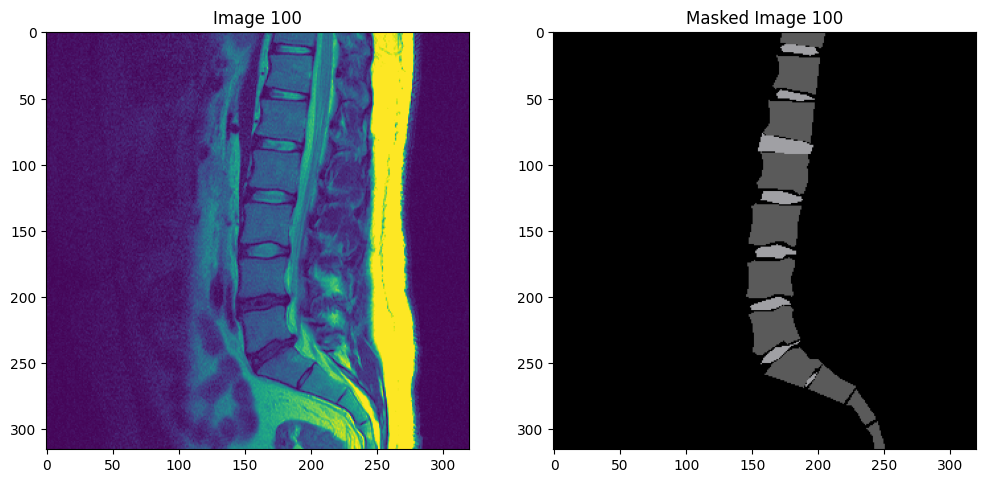

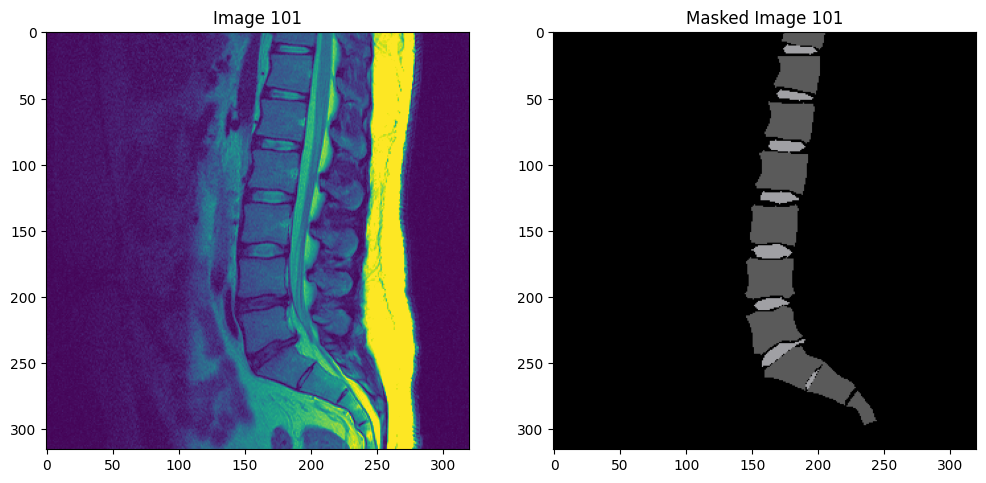

In [141]:
# рисуем изображения и маски
start_img = 0 #
stop_img = 2
for i in range(start_img, stop_img):
    img_view  = imageio.imread(path1 + img[i]) # путь к изображению
    mask_view = imageio.imread(path2 + mask[i]) # путь к его маске

    print(img_view.shape)
    print(mask_view.shape)
    #print(mask_view.min(), mask_view.max())
    fig, arr = plt.subplots(1, 2, figsize=(12, 12))
    arr[0].imshow(img_view) # рисуем изображение
    arr[0].set_title('Image '+ str(i + 100))
    arr[1].imshow(mask_view) # рисуем маску
    arr[1].set_title('Masked Image '+ str(i + 100))

X Shape: (261, 128, 128, 3)
Y shape: (261, 128, 128, 1)
[0 1 2]


Text(0.5, 1.0, 'Processed Masked Image ')

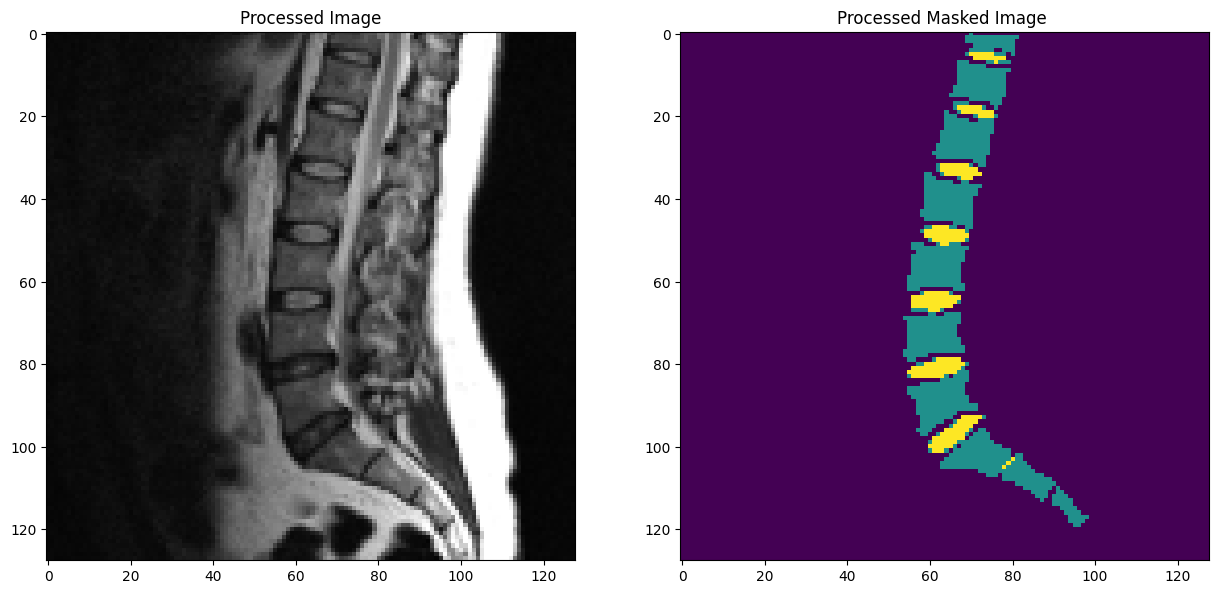

In [109]:
target_shape_img = [128, 128, 3] # размер изображений
target_shape_mask = [128, 128, 1] # размер масок

# обрабатываем
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

#
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# Классы : фон, объект, контур
print(np.unique(y))

# отображаем обработанные изображения и маски
image_index = 20
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index])
arr[1].set_title('Processed Masked Image ')

## Обучаем, оцениваем, тестируем

In [110]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [111]:
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

In [112]:
unet.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_140 (Conv2D)            (None, 128, 128, 32  896         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_141 (Conv2D)            (None, 128, 128, 32  9248        ['conv2d_140[0][0]']             
                                )                                                           

In [113]:
# оптимизатор Adam, функция ошибки - кроссэнтропия которая применяет softmax к выходам сети, метрика - аккуратность
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [128]:
# Обучаем ~ 10 минут (увеличьте число эпох)
results = unet.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
13/13 [==============================] - 120s 9s/step - loss: 0.1842 - accuracy: 0.9241 - val_loss: 0.2009 - val_accuracy: 0.9218
Epoch 2/20
13/13 [==============================] - 122s 10s/step - loss: 0.2318 - accuracy: 0.9241 - val_loss: 0.2094 - val_accuracy: 0.9218
Epoch 3/20
13/13 [==============================] - 124s 10s/step - loss: 0.1840 - accuracy: 0.9241 - val_loss: 0.1716 - val_accuracy: 0.9218
Epoch 4/20
13/13 [==============================] - 121s 9s/step - loss: 0.1677 - accuracy: 0.9249 - val_loss: 0.1626 - val_accuracy: 0.9252
Epoch 5/20
13/13 [==============================] - 120s 9s/step - loss: 0.1520 - accuracy: 0.9296 - val_loss: 0.1528 - val_accuracy: 0.9292
Epoch 6/20
13/13 [==============================] - 122s 9s/step - loss: 0.1422 - accuracy: 0.9374 - val_loss: 0.1316 - val_accuracy: 0.9450
Epoch 7/20
13/13 [==============================] - 124s 9s/step - loss: 0.1323 - accuracy: 0.9469 - val_loss: 0.1263 - val_accuracy: 0.9512
Epoch 8/20


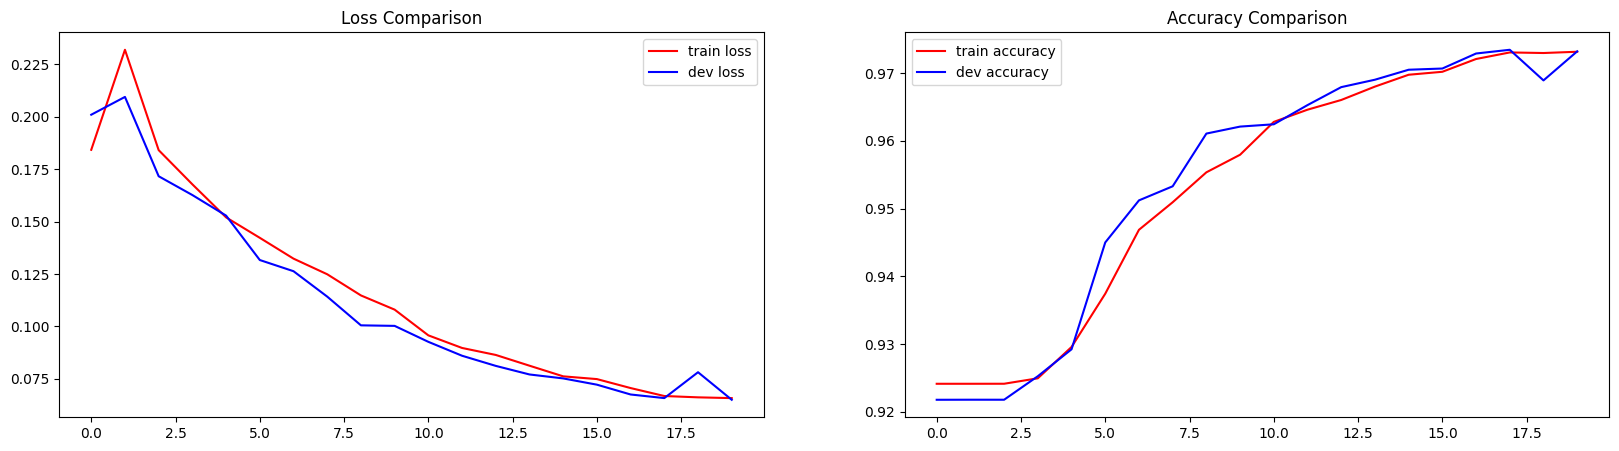

In [129]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

In [130]:
unet.evaluate(X_valid, y_valid)

2/2 [==============================] - 8s 3s/step - loss: 0.0650 - accuracy: 0.9732


[0.06503383070230484, 0.9732332229614258]

In [144]:
def VisualizeResults(index):
    img = X_valid[index] # изображение
    img = img[np.newaxis, ...] # добавляем измерение примеров
    pred_y = unet.predict(img) # расчитываем маску
    pred_mask = tf.argmax(pred_y[0], axis=-1) # выбираем максимальный класс (канал - последнее измерение)
    pred_mask = pred_mask[..., tf.newaxis] # канальное измерение добавляем
    # рисуем
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

1/1 [==============================] - 0s 338ms/step


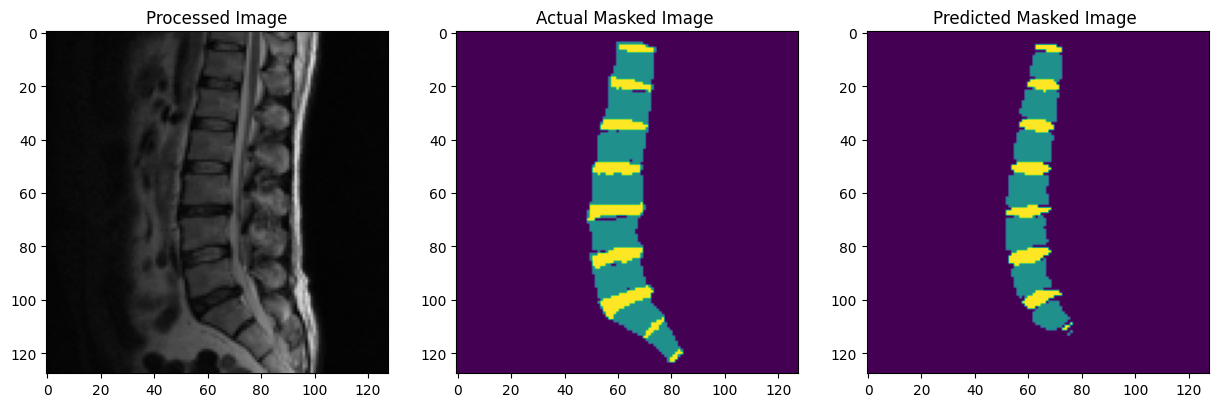

In [147]:
index = 4
VisualizeResults(index)

1/1 [==============================] - 0s 406ms/step


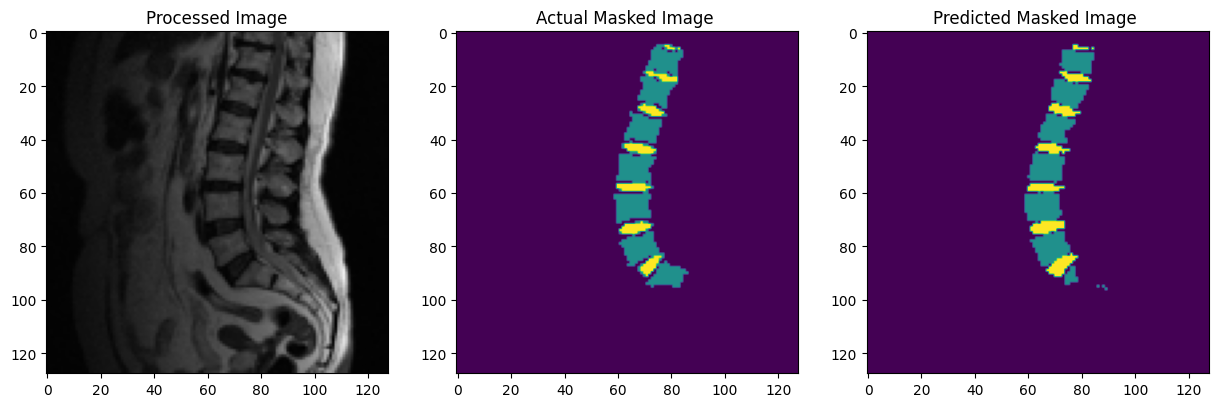

In [146]:
index = 6
VisualizeResults(index)